In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from xgboost import XGBClassifier


In [2]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1_score": f1_score(y, y_pred),
        "roc_auc": roc_auc_score(y, y_prob)
    }


In [6]:
# Load dataset
df = pd.read_csv("Churn_Modelling.csv")



In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [10]:
target = 'Exited'
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

X = df.drop(columns=[target])
y = df[target]

In [19]:
# -----------------------------
# 4. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

In [14]:
models = {
    'logreg': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf': RandomForestClassifier(n_estimators=300, max_depth=None, class_weight='balanced', n_jobs=-1),
    'xgb': XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, 
                         subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', n_jobs=-1),
    'svm_rbf': SVC(kernel='rbf', class_weight='balanced', probability=True)
}

In [15]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_prob)
    }


In [16]:
import mlflow
import dagshub

In [17]:
# ========================== CONFIG ==========================
CONFIG = {
    "experiment_name": "Fast_Model_Selection for customer churn",
    "mlflow_uri": "https://dagshub.com/VIKR4NT10/codesoft.mlflow",
    "repo_owner": "VIKR4NT10",
    "repo_name": "codesoft"
}

# ========================== MLflow + DAGsHub ==========================
mlflow.set_tracking_uri(CONFIG["mlflow_uri"])
dagshub.init(
    repo_owner=CONFIG["repo_owner"],
    repo_name=CONFIG["repo_name"],
    mlflow=True
)
mlflow.set_experiment(CONFIG["experiment_name"])

Accessing as VIKR4NT10

Initialized MLflow to track repo "VIKR4NT10/codesoft"

Repository VIKR4NT10/codesoft initialized!

2026/01/24 20:10:15 INFO mlflow.tracking.fluent: Experiment with name 'Fast_Model_Selection for customer churn' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/24773dd6667949b08dd527e9ad07556f', creation_time=1769265571500, experiment_id='8', last_update_time=1769265571500, lifecycle_stage='active', name='Fast_Model_Selection for customer churn', tags={}>

In [21]:
mlflow.set_experiment("customer_churn")
results = []

for model_name, model in models.items():
    print(f"\nTraining model: {model_name}...")

    with mlflow.start_run(run_name=model_name):

        mlflow.log_param("model", model_name)
        mlflow.log_param("rows", len(X_train))

        # Build pipeline
        pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Evaluate
        metrics = evaluate(pipeline, X_test, y_test)

        for k, v in metrics.items():
            mlflow.log_metric(k, float(v))

        mlflow.sklearn.log_model(pipeline, "model")

        results.append({
            'model': model_name,
            **metrics
        })

# -----------------------------
# 9. Results Summary
# -----------------------------
results_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
print("\nModel Comparison:\n", results_df)


Training model: logreg...


2026/01/24 20:16:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run logreg at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9/runs/fe1ad2289cbf46a894d028bcaaabd7c2
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9

Training model: rf...


2026/01/24 20:17:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rf at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9/runs/2c460788c9144e1b8f31895bedab155e
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9

Training model: xgb...


2026/01/24 20:19:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run xgb at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9/runs/79ac9a4c33c84af79b810e29866f1395
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9

Training model: svm_rbf...


2026/01/24 20:20:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run svm_rbf at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9/runs/2d0629414fbc4bc6b26c0da17d4e8b70
🧪 View experiment at: https://dagshub.com/VIKR4NT10/codesoft.mlflow/#/experiments/9

Model Comparison:
      model  accuracy  precision    recall  f1_score   roc_auc
1       rf    0.8575   0.765217  0.432432  0.552590  0.854713
2      xgb    0.8640   0.756654  0.488943  0.594030  0.854406
3  svm_rbf    0.7890   0.487923  0.744472  0.589494  0.853230
0   logreg    0.7135   0.387228  0.700246  0.498688  0.777165


In [23]:
trained_pipelines = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    trained_pipelines[model_name] = pipeline 

Training logreg...
Training rf...
Training xgb...
Training svm_rbf...


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Use the pipelines we just trained
xgb_pipeline = trained_pipelines['xgb']
svm_pipeline = trained_pipelines['svm_rbf']

models_to_check = {
    "XGBoost": xgb_pipeline,
    "SVM": svm_pipeline
}

thresholds = np.arange(0.0, 1.01, 0.05)

In [26]:
# -----------------------------
# Store results
# -----------------------------
results = {}

for model_name, pipeline in models_to_check.items():
    y_probs = pipeline.predict_proba(X_test)[:,1]  # predicted probabilities
    recalls = []
    precisions = []
    f1s = []

    for t in thresholds:
        y_pred_thresh = (y_probs >= t).astype(int)
        recalls.append(recall_score(y_test, y_pred_thresh))
        precisions.append(precision_score(y_test, y_pred_thresh))
        f1s.append(f1_score(y_test, y_pred_thresh))
    
    results[model_name] = {
        "thresholds": thresholds,
        "recall": recalls,
        "precision": precisions,
        "f1": f1s
    }

c:\Users\DELL\.conda\envs\titan\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\.conda\envs\titan\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


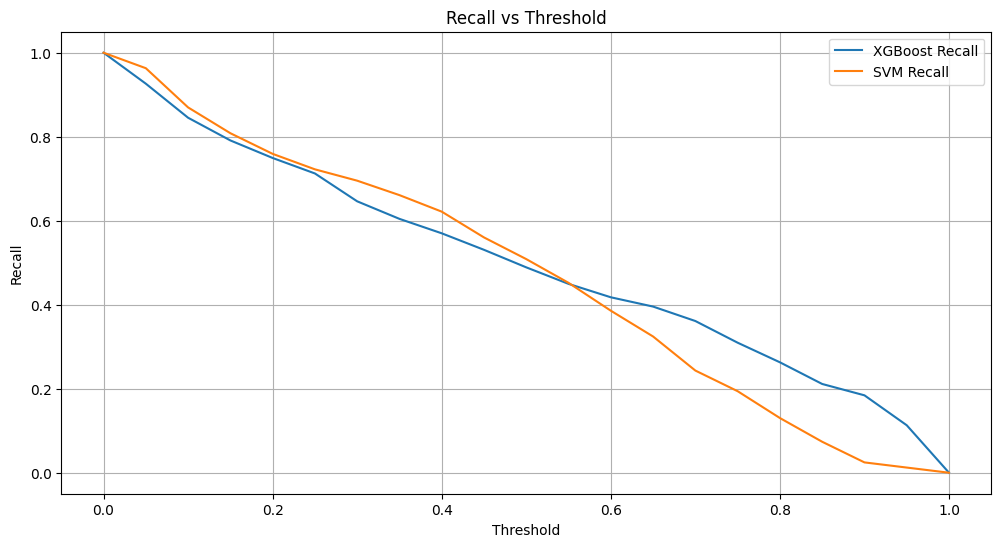

In [27]:
# -----------------------------
# Plot Recall vs Threshold
# -----------------------------
plt.figure(figsize=(12, 6))
for model_name in results:
    plt.plot(results[model_name]["thresholds"], results[model_name]["recall"], label=f"{model_name} Recall")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

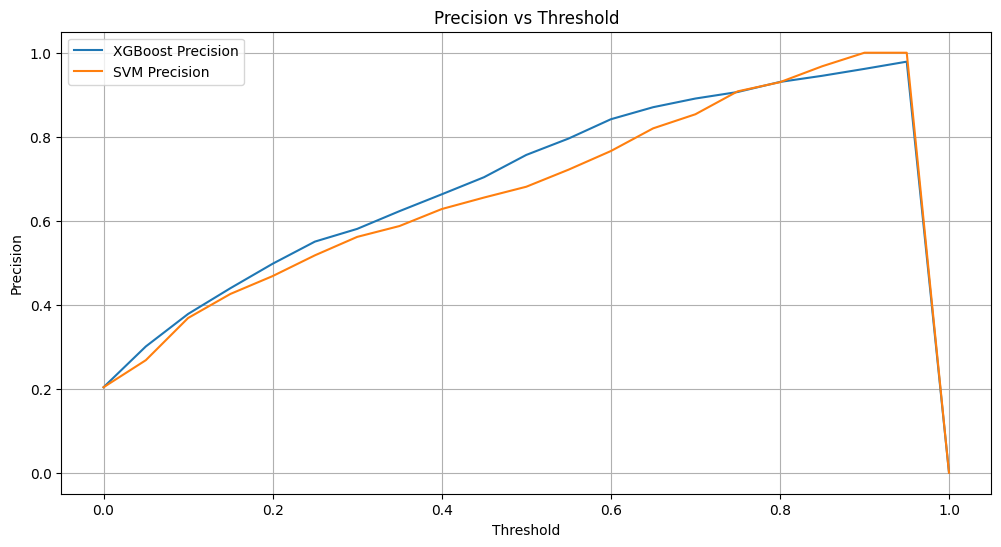

In [28]:
# -----------------------------
# Plot Precision vs Threshold
# -----------------------------
plt.figure(figsize=(12, 6))
for model_name in results:
    plt.plot(results[model_name]["thresholds"], results[model_name]["precision"], label=f"{model_name} Precision")
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Pipelines already trained
models_to_check = {
    "xgboost": trained_pipelines["xgb"],
    "svm_rbf": trained_pipelines["svm_rbf"]
}

thresholds = np.arange(0.05, 1.01, 0.05)

rows = []

for model_name, pipeline in models_to_check.items():
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)

        rows.append({
            "model": model_name,
            "threshold": round(t, 2),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "pct_customers_flagged": y_pred.mean()
        })

threshold_table = pd.DataFrame(rows)
threshold_table

c:\Users\DELL\.conda\envs\titan\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\.conda\envs\titan\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model,threshold,precision,recall,f1_score,pct_customers_flagged
0,xgboost,0.05,0.300638,0.926290,0.453943,0.6270
1,xgboost,0.10,0.378022,0.845209,0.522399,0.4550
2,xgboost,0.15,0.439291,0.791155,0.564912,0.3665
3,xgboost,0.20,0.497553,0.749386,0.598039,0.3065
4,xgboost,0.25,0.550285,0.712531,0.620985,0.2635
5,xgboost,0.30,0.580574,0.646192,0.611628,0.2265
6,xgboost,0.35,0.622785,0.604423,0.613466,0.1975
7,xgboost,0.40,0.662857,0.570025,0.612946,0.1750
8,xgboost,0.45,0.703583,0.530713,0.605042,0.1535
9,xgboost,0.50,0.756654,0.488943,0.594030,0.1315


In [42]:
MAX_CONTACT_RATE = 0.25

decision_table = threshold_table[
    threshold_table["pct_customers_flagged"] <= MAX_CONTACT_RATE
]

decision_table.sort_values(
    by=["recall", "precision"],
    ascending=[False, False]
).head(10)

,model,threshold,precision,recall,f1_score,pct_customers_flagged
26,svm_rbf,0.35,0.587336,0.660934,0.621965,0.2290
5,xgboost,0.30,0.580574,0.646192,0.611628,0.2265
27,svm_rbf,0.40,0.627792,0.621622,0.624691,0.2015
6,xgboost,0.35,0.622785,0.604423,0.613466,0.1975
7,xgboost,0.40,0.662857,0.570025,0.612946,0.1750
28,svm_rbf,0.45,0.655172,0.560197,0.603974,0.1740
8,xgboost,0.45,0.703583,0.530713,0.605042,0.1535
29,svm_rbf,0.50,0.680921,0.508600,0.582278,0.1520
9,xgboost,0.50,0.756654,0.488943,0.594030,0.1315
30,svm_rbf,0.55,0.721569,0.452088,0.555891,0.1275


In [46]:

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

svm_model = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=True,
    random_state=42
)


In [47]:
def cross_validate_pipeline(model, X, y, model_name):
    rows = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("model", model)
        ])

        pipeline.fit(X_tr, y_tr)

        y_pred = pipeline.predict(X_val)
        y_prob = pipeline.predict_proba(X_val)[:, 1]

        rows.append({
            "model": model_name,
            "fold": fold,
            "precision": precision_score(y_val, y_pred),
            "recall": recall_score(y_val, y_pred),
            "f1_score": f1_score(y_val, y_pred),
            "roc_auc": roc_auc_score(y_val, y_prob)
        })

    return pd.DataFrame(rows)


In [48]:
xgb_cv_results = cross_validate_pipeline(
    xgb_model, X, y, "xgboost"
)

svm_cv_results = cross_validate_pipeline(
    svm_model, X, y, "svm_rbf"
)

cv_results = pd.concat([xgb_cv_results, svm_cv_results])
cv_results


,model,fold,precision,recall,f1_score,roc_auc
0,xgboost,1,0.716312,0.495098,0.585507,0.865532
1,xgboost,2,0.740741,0.441176,0.552995,0.851696
2,xgboost,3,0.732639,0.518428,0.607194,0.859778
3,xgboost,4,0.780669,0.515971,0.621302,0.868992
4,xgboost,5,0.771084,0.471744,0.585366,0.869622
0,svm_rbf,1,0.495208,0.759804,0.599613,0.855244
1,svm_rbf,2,0.482877,0.691176,0.568548,0.835459
2,svm_rbf,3,0.487923,0.744472,0.589494,0.854431
3,svm_rbf,4,0.476117,0.759214,0.585227,0.848961
4,svm_rbf,5,0.542190,0.742015,0.626556,0.860073
